In [1]:
%matplotlib inline

import os
import datetime
import glob
import pandas as pd
import numpy as np
from numpy.fft import fft, ifft, fftfreq
from nilearn.glm.first_level import FirstLevelModel, first_level_from_bids
from nilearn.glm.second_level import SecondLevelModel
from nilearn.image import concat_imgs, mean_img, load_img
from nilearn import plotting
import matplotlib.pyplot as plt
from nilearn.plotting import plot_design_matrix, plot_stat_map

/home/local/TU/tui81100/.local/lib/python3.9/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


In [2]:
# Setting Directory
data_dir = '/data/Uncertainty/data'
task_label = "uncertainty"
derivatives_folder = 'deriv/pipeline_1/fmriprep'

In [3]:
(models, 
 models_run_imgs, 
 models_events, 
 models_confounds,) = first_level_from_bids(data_dir, 
                                            task_label, 
                                            img_filters=[("desc", "preproc")], 
                                            derivatives_folder = derivatives_folder, 
                                            n_jobs = 2)

/home/local/TU/tui81100/.local/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:901: UserWarning: SliceTimingRef not found in file /data/Uncertainty/data/deriv/pipeline_1/fmriprep/sub-0035/func/sub-0035_task-uncertainty_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.json. It will be assumed that the slice timing reference is 0.0 percent of the repetition time. If it is not the case it will need to be set manually in the generated list of models
  warn('SliceTimingRef not found in file %s. It will be assumed'


ValueError: No events.tsv files found

In [3]:
# Defining which subjects rated in the first half of the video
subs_active = ['sub-0208', 'sub-2610', 'sub-2758', 'sub-3046', 'sub-3801',
                'sub-3951', 'sub-4407', 'sub-4590', 'sub-6021', 'sub-6269',
                'sub-6773', 'sub-6799', 'sub-7758', 'sub-8607', 'sub-8621',
                'sub-8746', 'sub-9439','sub-9827', 'sub-9907']

# Defining which subjects rated in the first half of the video
subs_passive = ['sub-0295', 'sub-0757', 'sub-2579', 'sub-3011', 'sub-3274',
                'sub-3952', 'sub-3981', 'sub-4781', 'sub-5006', 'sub-5849',
                'sub-6215', 'sub-6971', 'sub-6977', 'sub-7255', 'sub-7492', 
                'sub-8929']

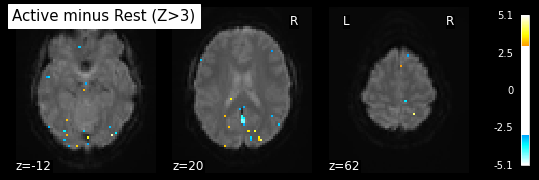

In [10]:
# Creating a generic first level model
fmri_glm = FirstLevelModel(t_r = 2,
                           noise_model="ar1",
                           standardize=False,
                           hrf_model="spm",
                           drift_model="cosine",
                           high_pass=0.01,)

# iterating through all active subs 
SUB = "sub-0208"
    
# Iterating through all runs
RUN = 2

# Save the filepath to this subject as an object
path = os.path.join(data_dir, SUB, 'func',f'{SUB}_task-uncertainty_run-{RUN}_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz')

# If the total number of volumes does not include the additional 30s fixation
if load_img(path).shape[-1] == 729 and RUN == 1:

    # Create the events file
    events = pd.DataFrame(data = {"onset": [0.0, 60, 1398],
                                 "duration": [60, 1398, 1458],
                                 "trial_type": ["ISI", "Target", "ISI"]})

# If the total number of volumes includes the additional 30s fixation
if load_img(path).shape[-1] == 759 and RUN == 1:

    # Create the events file
    events = pd.DataFrame(data = {"onset": [0.0, 90, 1428],
                                 "duration": [90, 1428, 1518],
                                 "trial_type": ["ISI", "Target", "ISI"]})

# If the total number of volumes does not include the additional 30s fixation
if load_img(path).shape[-1] == 729 and RUN == 2:

    # Create the events file
    events = pd.DataFrame(data = {"onset": [0.0, 60, 1398],
                                 "duration": [60, 1398, 1458],
                                 "trial_type": ["ISI", "Target", "ISI"]})

# If the total number of volumes includes the additional 30s fixation
if load_img(path).shape[-1] == 759 and RUN == 2:

    # Create the events file
    events = pd.DataFrame(data = {"onset": [0.0, 90, 1428],
                                 "duration": [90, 1428, 1518],
                                 "trial_type": ["ISI", "Target", "ISI"]})

# Fitting the glm to this participants data
fmri_glm = fmri_glm.fit(path, events)

# Creating a conditions dictionary
conditions = {"Target": np.zeros(32), "ISI": np.zeros(32)}
conditions["Target"][0] = 1
conditions["ISI"][1] = 1

# Defining our contrast
contrast = conditions["Target"] - conditions["ISI"]

# Computing the estimated effects
eff_map = fmri_glm.compute_contrast(
    contrast, output_type="effect_size"
)

# Creating a z map
z_map = fmri_glm.compute_contrast(contrast, output_type="z_score")

# Visualizing the results
plot_stat_map(
    z_map,
    bg_img=mean_img(path),
    threshold=3.0,
    display_mode="z",
    cut_coords=3,
    black_bg=True,
    title="Active minus Rest (Z>3)",
)
plt.show()

In [4]:
def file_finder(subs, run, directory, data_type = "anat"):
    
    # Creating an empty array
    array = []

    # Load the preprocessed fMRI data for both groups
    for SUB in subs:
        
        # Data type 
        if data_type == "func":
        
            # Save the filepath to this subject as an object
            path = os.path.join(directory, SUB, 'func',f'{SUB}_task-uncertainty_run-{run}_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz')
            
        # Data type
        if data_type == "anat":
            
            # Save the filepath to this subject as an object
            path = os.path.join(directory, SUB, 'anat',f'{SUB}_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz')
                    
        # Append it to this array
        array.append(path)
        
    # Return the Array
    return array
    

In [5]:
# Creating filepath arrays
func_active_R1 = file_finder(subs = subs_active,
                             run = 1, 
                             directory = data_dir,
                             data_type = "func")

func_passive_R1 = file_finder(subs = subs_passive, 
                             run = 1, 
                             directory = data_dir,
                             data_type = "func")

func_active_R2 = file_finder(subs = subs_passive, 
                          run = 2, 
                          directory = data_dir,
                             data_type = "func")

func_passive_R2 = file_finder(subs = subs_active, 
                             run = 2, 
                             directory = data_dir,
                             data_type = "func")

In [6]:
# Concatenate the images from both groups
all_func_R1 = func_active_R1 + func_passive_R1
all_func_R2 = func_active_R2 + func_passive_R2
all_func = all_func_R1 + all_func_R2

In [7]:
# Creating filepath arrays
anat_active = file_finder(subs = subs_active,
                          run = None,
                             directory = data_dir,
                             data_type = "anat")

anat_passive = file_finder(subs = subs_passive,
                           run = None,
                             directory = data_dir,
                             data_type = "anat")

In [8]:
# Concatenate the images from both groups
all_anat = anat_active + anat_passive

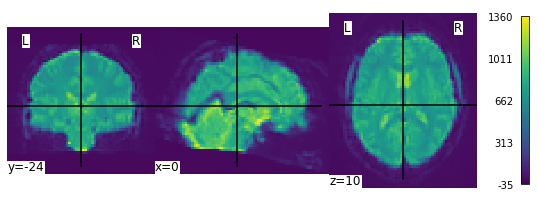

In [9]:
# Print a functional image 
plotting.plot_img(mean_img(all_func[0]), colorbar = True, cbar_tick_format = "%i")
plotting.show()

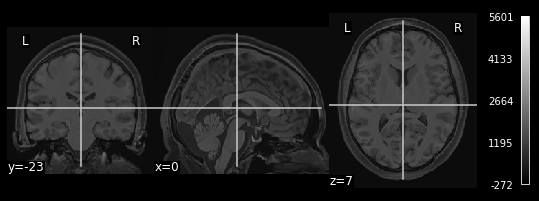

In [10]:
# Print an anatomical image
plotting.plot_anat(mean_img(all_anat[0]), colorbar = True, cbar_tick_format = "%i")
plotting.show()

In [7]:
# Create the design matrix
# 1 for subjects in the rating group, 0 for subjects in the non-rating group
group_indicator = np.array([1] * len(data_active_R1) + [-1] * len(data_passive_R1)).reshape(-1, 1)
display(group_indicator)

array([[ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1]])

In [8]:
design_matrix = np.hstack([group_indicator, np.ones_like(group_indicator)])
display(design_matrix)

array([[ 1,  1],
       [ 1,  1],
       [ 1,  1],
       [ 1,  1],
       [ 1,  1],
       [ 1,  1],
       [ 1,  1],
       [ 1,  1],
       [ 1,  1],
       [ 1,  1],
       [ 1,  1],
       [ 1,  1],
       [ 1,  1],
       [ 1,  1],
       [ 1,  1],
       [ 1,  1],
       [ 1,  1],
       [ 1,  1],
       [-1,  1],
       [-1,  1],
       [-1,  1],
       [-1,  1],
       [-1,  1],
       [-1,  1],
       [-1,  1],
       [-1,  1],
       [-1,  1],
       [-1,  1],
       [-1,  1],
       [-1,  1],
       [-1,  1],
       [-1,  1],
       [-1,  1],
       [-1,  1]])

In [9]:
# Convert the design matrix to a pandas DataFrame
design_matrix_df = pd.DataFrame(design_matrix, columns=['Group', 'Intercept'])
display(design_matrix)

array([[ 1,  1],
       [ 1,  1],
       [ 1,  1],
       [ 1,  1],
       [ 1,  1],
       [ 1,  1],
       [ 1,  1],
       [ 1,  1],
       [ 1,  1],
       [ 1,  1],
       [ 1,  1],
       [ 1,  1],
       [ 1,  1],
       [ 1,  1],
       [ 1,  1],
       [ 1,  1],
       [ 1,  1],
       [ 1,  1],
       [-1,  1],
       [-1,  1],
       [-1,  1],
       [-1,  1],
       [-1,  1],
       [-1,  1],
       [-1,  1],
       [-1,  1],
       [-1,  1],
       [-1,  1],
       [-1,  1],
       [-1,  1],
       [-1,  1],
       [-1,  1],
       [-1,  1],
       [-1,  1]])

In [21]:
# Fit the second-level model
model = SecondLevelModel(smoothing_fwhm=6.0)
model = model.fit(concat_imgs(all_data_R1), design_matrix=design_matrix_df)
display(model)

SecondLevelModel(smoothing_fwhm=6.0)

In [22]:
# Specify the contrast (rating > non-rating)
contrast = [1, -1]

# Compute the contrast map
contrast_map = model.compute_contrast(contrast, output_type='z_score')

# Save the contrast map
contrast_map.to_filename('rating_effect_z_map.nii.gz')

TypeError: Cannot slice image objects; consider using `img.slicer[slice]` to generate a sliced image (see documentation for caveats) or slicing image array data with `img.dataobj[slice]` or `img.get_fdata()[slice]`